In [225]:
import tejapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
tejapi.ApiConfig.api_key = '1nn6JiPLutgvyiYdYHBf5S3TH1wZ1J'
tejapi.ApiConfig.ignoretz = True

In [226]:
#長榮 2603 籌碼 https://api.tej.com.tw/columns.html?idCode=TRAIL/TATINST1
evergreen_chip = tejapi.get('TRAIL/TATINST1',
                            coid = '2603',
                            paginate = True,
                            opts = {'columns':['coid','mdate','qfii_ex1','fund_ex','dlr_ex','ttl_ex','fld024']},
                            chinese_column_name = True
                           )
#長榮 2603 股價 https://api.tej.com.tw/columns.html?idCode=TRAIL/TAPRCD
evergreen_price = tejapi.get('TRAIL/TAPRCD',
                            coid = '2603',
                            paginate = True,
                            opts = {'columns':['mdate','open_d', 'roi']},
                            chinese_column_name = True
                           )
evergreen_price['次日開盤價'] = evergreen_price['開盤價(元)'].shift(-1)
#市場報酬
market = tejapi.get('TRAIL/TAPRCD',
                            coid = 'TWN50',
                            paginate = True,
                            opts = {'columns':['mdate', 'roi']},
                            chinese_column_name = True
                           )
market = market.rename(columns = {'報酬率％':'市場報酬率'})
#合併
evergreen = evergreen_chip.merge(evergreen_price[['年月日','次日開盤價','報酬率％']], on = '年月日')
evergreen = evergreen.merge(market, on = '年月日')
evergreen = evergreen.rename(columns = {'報酬率％':'日報酬率％'})


In [227]:
ev = evergreen.copy().dropna() #備份
ev

,證券名稱,年月日,外資買賣超(千股),投信買賣超(千股),自營買賣超(千股),合計買賣超(千股),合計持股率%,次日開盤價,日報酬率％,市場報酬率
0,2603,2020-01-02,3600,0,1081,4681,24.43,12.80,2.4194,1.0139
1,2603,2020-01-03,3427,1500,2707,7634,24.57,13.00,2.3622,0.2616
2,2603,2020-01-06,-3728,466,1329,-1933,24.52,13.00,0.0000,-1.5974
3,2603,2020-01-07,-2534,30,275,-2229,24.47,12.75,-0.7692,-0.5566
4,2603,2020-01-08,-2848,-127,-995,-3970,24.39,12.75,-2.3256,-0.5217
...,...,...,...,...,...,...,...,...,...,...
239,2603,2020-12-24,104,852,-396,560,33.06,33.00,0.9772,0.3279
240,2603,2020-12-25,28404,3429,4636,36469,33.82,34.75,7.9032,0.3288
241,2603,2020-12-28,2779,1724,2479,6982,33.96,39.00,9.8655,0.8832
242,2603,2020-12-29,-62474,-5275,-1914,-69663,32.52,38.00,4.3537,-0.1253


<ipython-input-224-6dfe49d8fc64>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev['訊號'][len(ev)-1] = 'Sell'


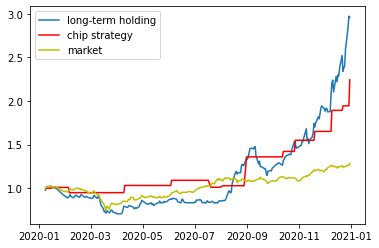

,籌碼面,長期持有,市場
年化報酬(%),133.618932,212.640661,30.009563
年化標準差(%),43.667737,47.158672,23.186222
夏普比率,3.037000,4.487842,1.251155


In [224]:
#有很多買賣點組合，看哪個績效好
ev['三大法人皆買超'] = np.where((ev['外資買賣超(千股)'] >= 0) & (ev['投信買賣超(千股)'] >= 0) & (ev['自營買賣超(千股)'] >= 0), 1, 0) 
ev['三大法人皆賣超'] = np.where((ev['外資買賣超(千股)'] < 0) & (ev['投信買賣超(千股)'] < 0) & (ev['自營買賣超(千股)'] < 0), 1, 0) 
ev['合計買賣超'] = np.where(ev['合計買賣超(千股)'] >= 0, 1, 0)  
ev['合計持股變化'] = np.where(ev['合計持股率%'] - ev['合計持股率%'].shift(1) > 0, 1, 0)
ev['rolling_持股率'] = ev['合計持股率%'].rolling(5).mean()
ev = ev.dropna().reset_index(drop = True) #去除NaN
ev['合計持股趨勢'] = np.where(ev['合計持股率%'] - ev['rolling_持股率'] > 0, 1, 0) 
#設定訊號 
ev['訊號'] = np.where((ev['合計買賣超'] == 1)&(ev['合計持股趨勢'] == 0), 'Buy', '') #買點
ev['訊號'] = np.where((ev['合計買賣超'] == 0)&(ev['合計持股趨勢'] == 1), 'Sell', ev['訊號']) #賣點
#年底出清，故把最後一筆資料改成sell
ev['訊號'][len(ev)-1] = 'Sell'
#回測報酬率(設投入一元，考慮買賣手續費0.1425%+證交稅0.3%)
ev['訊號'][len(ev)-1]
hold = 0
cost = 0
Return = []
for i in range(len(ev)):
    if ev['訊號'][i] == '':
        Return.append(0)
    elif ev['訊號'][i] == 'Buy':
        if hold == 0:
            cost = ev['次日開盤價'][i]
            hold = 1
            Return.append(0)
        else:
            Return.append(0)
    elif ev['訊號'][i] == 'Sell':
        if hold == 1:
            Return.append(100*(np.log(ev['次日開盤價'][i]/cost)- 0.001425*2 - 0.003))
            hold = 0
        else:
            Return.append(0)
ev['籌碼面報酬率(%)'] = Return
#累積報酬
ev['籌碼面累積報酬率'] = ev['籌碼面報酬率(%)'].apply(lambda x: 0.01*x+1).cumprod()
ev['長期持有累積日報酬率'] = ev['日報酬率％'].apply(lambda x: 0.01*x+1).cumprod()
ev['累積市場報酬率'] = ev['市場報酬率'].apply(lambda x: 0.01*x+1).cumprod()
#設定訊號 (1)================表現相對其他買賣點好，但長期持有仍勝
plt.plot(ev['年月日'], ev['長期持有累積日報酬率'], label = 'long-term holding')
plt.plot(ev['年月日'], ev['籌碼面累積報酬率'], color = 'r', label = 'chip strategy')
plt.plot(ev['年月日'], ev['累積市場報酬率'],color = 'y', label = 'market')
plt.legend()
plt.show()
#績效表
cagr = [100*(ev['籌碼面累積報酬率'].values[-1]**(252/len(ev)) - 1), 100*(ev['長期持有累積日報酬率'].values[-1]**(252/len(ev)) - 1), 100*(ev['累積市場報酬率'].values[-1]**(252/len(ev)) - 1)]
std = [ev['籌碼面報酬率(%)'].std()*(252**0.5),ev['日報酬率％'].std()*(252**0.5) ,ev['市場報酬率'].std()*(252**0.5)]
sharpe_ratio = [(cagr[0] - 1)/std[0],(cagr[1] - 1)/std[1] , (cagr[2] - 1)/std[2]]  #設rf = 1%
result = pd.DataFrame([cagr,std,sharpe_ratio], columns = ['籌碼面','長期持有','市場'], index = ['年化報酬(%)','年化標準差(%)','夏普比率'])
result


#原本rolling5 我改成rolling3，報酬超越長期持有

In [122]:
#                                             賣               買
#ev['三大法人皆買超'].value_counts()          0: 195         , 1:45
#ev['三大法人皆賣超'].value_counts()          1: 20          , 0:220
#ev['合計買賣超'].value_counts()              0: 115         , 1:125
#ev['合計持股變化'].value_counts()            1: 102         , 0:138
#ev['合計持股趨勢'].value_counts()            1: 114         , 0:126

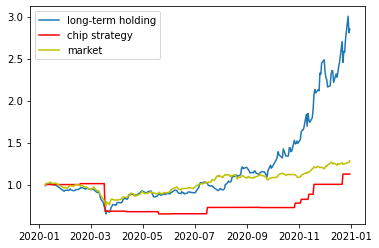

In [127]:
#設定訊號 (1)================表現相對其他買賣點好，但長期持有仍勝
#ev['訊號'] = np.where((ev['合計買賣超'] == 1)&(ev['合計持股趨勢'] == 0), 'Buy', '') #買點
#ev['訊號'] = np.where((ev['合計買賣超'] == 0)&(ev['合計持股趨勢'] == 1), 'Sell', ev['訊號']) #賣點
plt.plot(ev['年月日'], ev['長期持有累積日報酬率'], label = 'long-term holding')
plt.plot(ev['年月日'], ev['籌碼面累積報酬率'], color = 'r', label = 'chip strategy')
plt.plot(ev['年月日'], ev['累積市場報酬率'],color = 'y', label = 'market')
plt.legend()
plt.show()

In [128]:
#績效表
performance = pd.DataFrame()

cagr = [100*(ev['籌碼面累積報酬率'].values[-1]**(252/len(ev)) - 1), 100*(ev['長期持有累積日報酬率'].values[-1]**(252/len(ev)) - 1), 100*(ev['累積市場報酬率'].values[-1]**(252/len(ev)) - 1)]
std = [ev['籌碼面報酬率(%)'].std()*(252**0.5),ev['日報酬率％'].std()*(252**0.5) ,ev['市場報酬率'].std()*(252**0.5)]
sharpe_ratio = [(cagr[0] - 1)/std[0],(cagr[1] - 1)/std[1] , (cagr[2] - 1)/std[2]]  #設rf = 1%
result = pd.DataFrame([cagr,std,sharpe_ratio], columns = ['籌碼面','長期持有','市場'], index = ['年化報酬(%)','年化標準差(%)','夏普比率'])
result

,籌碼面,長期持有,市場
年化報酬(%),13.111475,200.352134,30.009563
年化標準差(%),41.893481,49.106747,23.186222
夏普比率,0.289102,4.059567,1.251155


In [ ]:
#以下改變買賣點，但績效不太好

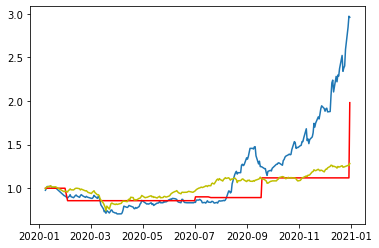

In [187]:
#設定訊號5 ================
#ev['訊號'] = np.where((ev['合計買賣超'] == 1)&(ev['合計持股變化'] == 0, 'Buy', '') #買點
#ev['訊號'] = np.where((ev['合計買賣超'] == 0)&(ev['合計持股變化'] == 1, 'Sell', ev['訊號']) #賣點
plt.plot(ev['年月日'], ev['累積日報酬率'])
plt.plot(ev['年月日'], ev['籌碼面累積報酬率'],'r')
plt.plot(ev['年月日'], ev['累積市場報酬率'],'y')
plt.show()

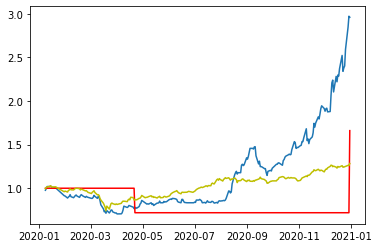

In [175]:
#設定訊號 4 ================
#ev['訊號'] = np.where((ev['合計買賣超'] == 1)&(ev['合計持股變化'] == 0), 'Buy', '') #買點
#ev['訊號'] = np.where((ev['三大法人皆賣超'] == 1)&(ev['合計持股變化'] == 1), 'Sell', ev['訊號']) #賣點
plt.plot(ev['年月日'], ev['累積日報酬率'])
plt.plot(ev['年月日'], ev['籌碼面累積報酬率'],'r')
plt.plot(ev['年月日'], ev['累積市場報酬率'],'y')
plt.show()

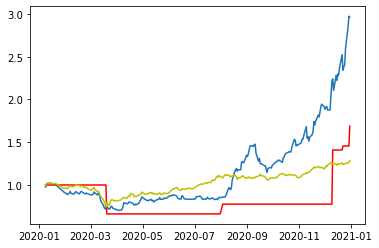

In [163]:
##設定訊號3 ================
#ev['訊號'] = np.where((ev['合計買賣超'] == 1)&(ev['合計持股趨勢'] == 0), 'Buy', '') #買點
#ev['訊號'] = np.where((ev['三大法人皆賣超'] == 1)&(ev['合計持股趨勢'] == 1), 'Sell', ev['訊號']) #賣點
plt.plot(ev['年月日'], ev['累積日報酬率'])
plt.plot(ev['年月日'], ev['籌碼面累積報酬率'],'r')
plt.plot(ev['年月日'], ev['累積市場報酬率'],'y')
plt.show()

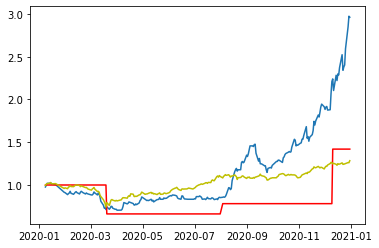

In [151]:
##設定訊號(2) ================
#ev['訊號'] = np.where((ev['三大法人皆買超'] == 1)&(ev['合計持股趨勢'] == 0), 'Buy', '') #買點
#ev['訊號'] = np.where((ev['三大法人皆賣超'] == 1)&(ev['合計持股趨勢'] == 1), 'Sell', ev['訊號']) #賣點
plt.plot(ev['年月日'], ev['累積日報酬率'])
plt.plot(ev['年月日'], ev['籌碼面累積報酬率'],'r')
plt.plot(ev['年月日'], ev['累積市場報酬率'],'y')
plt.show()